# *Using VGG16 + SVM to detect covid-19 based on x-ray*

In [1]:
import os
import numpy as np
import pandas as pd 
import random
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import keras
# Deep learning libraries
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, GlobalAveragePooling2D, MaxPool2D, LeakyReLU, Activation, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.regularizers import l2
import tensorflow as tf
import seaborn as sns
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import PIL

### LOAD DATA (4 LABELS)

In [2]:
path_normal = "../input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/images"
path_covid = "../input/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/images"
path_lung_opacity = "../input/covid19-radiography-database/COVID-19_Radiography_Dataset/Lung_Opacity/images"
path_viral_pneumonia = "../input/covid19-radiography-database/COVID-19_Radiography_Dataset/Viral Pneumonia/images"

len_normal = len(os.listdir(path_normal))
len_covid = len(os.listdir(path_covid))
len_lung_opacity =  len(os.listdir(path_lung_opacity))
len_viral_pneumonia = len(os.listdir(path_viral_pneumonia))

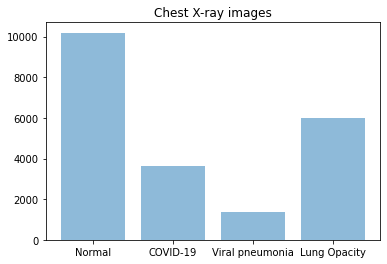

In [3]:
objects = ('Normal', 'COVID-19', 'Viral pneumonia', 'Lung Opacity')
x_pos = np.arange(len(objects))
performance = [len_normal, len_covid, len_viral_pneumonia, len_lung_opacity]

plt.bar(x_pos,performance, align='center', alpha=0.5)
plt.xticks(x_pos, objects)
plt.title('Chest X-ray images')

plt.show()

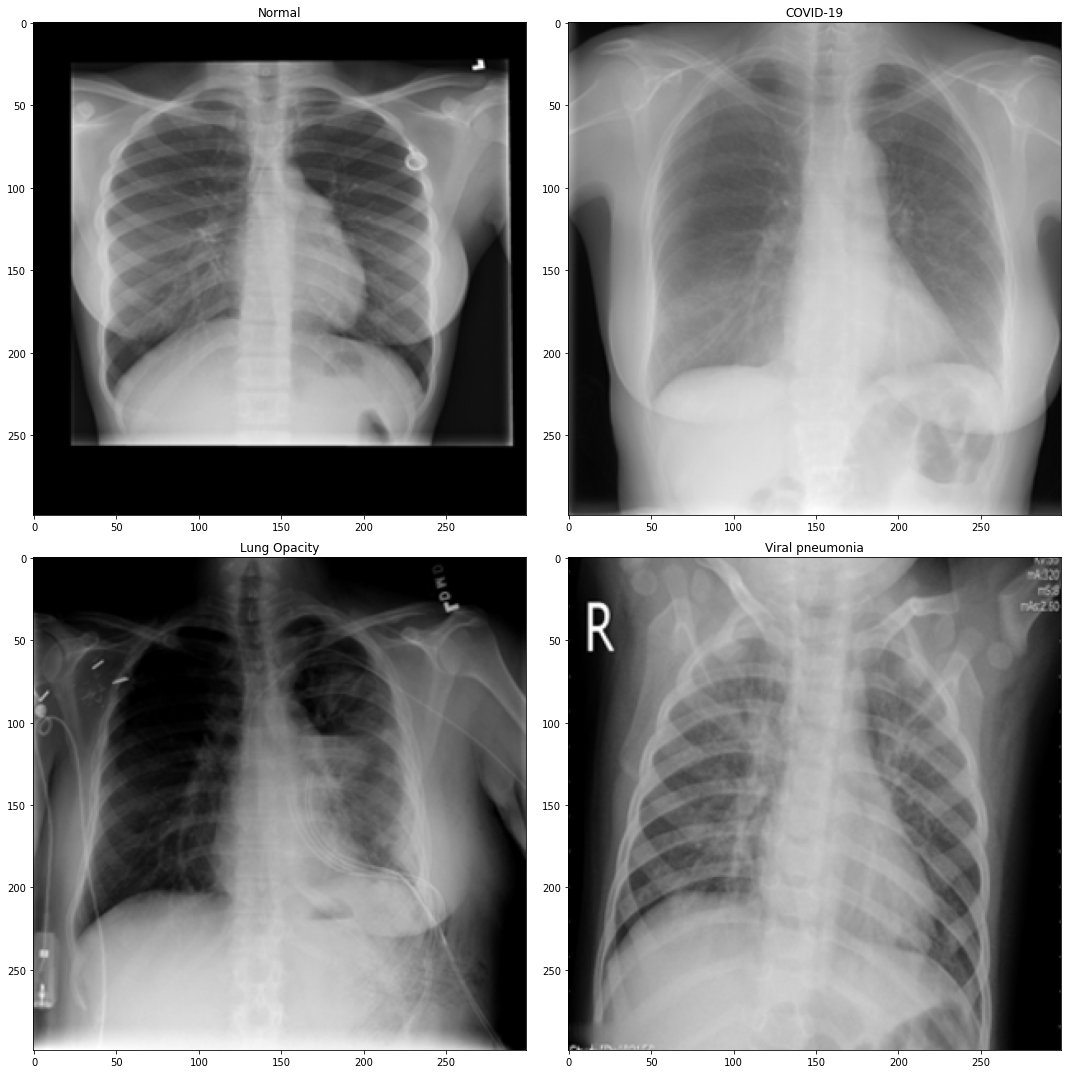

In [4]:
labels = ['Normal', 'COVID-19','Lung Opacity', 'Viral pneumonia']
img1 = path_normal+"/Normal-1.png"
img2 = path_covid+"/COVID-1994.png"
img3 = path_lung_opacity+"/Lung_Opacity-1.png"
img4 = path_viral_pneumonia + "/Viral Pneumonia-1.png"

imgs = [img1, img2, img3, img4]

fig, ax = plt.subplots(2, 2, figsize=(15, 15))
ax = ax.ravel()
plt.tight_layout()

for i in range(0,4):

    ax[i].imshow(plt.imread(imgs[i]), cmap='gray')
    ax[i].set_title(labels[i])

### PREPROCESSING

In [5]:
from PIL import Image, ImageOps
def resize_image(imgpath):
    img = np.array(ImageOps.colorize(Image.open(imgpath).resize((150,150), PIL.Image.Resampling.LANCZOS), black="gray", white="white"))
    return img

In [6]:
import os
x_ = list()
y = list()

for i in os.listdir(path_normal):
    try:
        imgpath = path_normal+"/"+i
#         img = hist(imgpath)
#         img = resize_image(img)
        img = resize_image(imgpath)
        x_.append(img)
        y.append(0)
    except:
        None
        
for i in os.listdir(path_covid):
    try:
        imgpath = path_covid+"/"+i
#         img = hist(imgpath)
#         img = resize_image(img)
        img = resize_image(imgpath)
        x_.append(img)
        y.append(1)
    except:
        None
        
for i in os.listdir(path_lung_opacity):
    try:
        imgpath = path_lung_opacity+"/"+i
#         img = hist(imgpath)
#         img = resize_image(img)
        img = resize_image(imgpath)
        x_.append(img)
        y.append(2)
    except:
        None

for i in os.listdir(path_viral_pneumonia):
    try:
        imgpath = path_viral_pneumonia+"/"+i
#         img = hist(imgpath)
#         img = resize_image(img)
        img = resize_image(imgpath)
        x_.append(img)
        y.append(3)
    except:
        None

x_ = np.array(x_)

> ### Split train, validation and test data

In [7]:
from keras.utils.np_utils import to_categorical

y = to_categorical(y,num_classes = 4)

classNames = ["normal","COVID_19", "lung_opacity","viral_pneumonia"]
print(classNames)

['normal', 'COVID_19', 'lung_opacity', 'viral_pneumonia']


In [8]:
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test = train_test_split(x_,y,test_size = 0.2,random_state = 20)

x_train,x_val,y_train,y_val = train_test_split(x_train,y_train,test_size = 0.15,random_state = 40)

In [9]:
print(x_train.shape)
y_train = np.asarray(y_train)
y_val = np.asarray(y_val)
y_test = np.asarray(y_test)
print(y_train.shape)

(14297, 150, 150, 3)
(14297, 4)


### VGG16 pre-trained Model + SVM

In [10]:
vgg16Model = tf.keras.applications.VGG16(weights= 'imagenet', include_top = False, input_shape=(150,150,3))
for layer in vgg16Model.layers[:-3]:
  layer.trainable = False

headModel = vgg16Model.output
headModel = GlobalAveragePooling2D()(headModel)
headModel = BatchNormalization()(headModel)

headModel = Dense(128, activation="relu")(headModel)
headModel = BatchNormalization()(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = BatchNormalization()(headModel)

headModel = Dense(4, activation="softmax", kernel_regularizer=l2(1e-3))(headModel)
model = Model(inputs=vgg16Model.input, outputs=headModel)
model.compile(loss=keras.losses.CategoricalHinge(), optimizer='adam', metrics=['accuracy'])

2022-10-04 04:22:32.723438: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-04 04:22:32.826281: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-04 04:22:32.827092: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-04 04:22:32.828035: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

58900480/58889256 [==============================] - 0s 0us/step


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

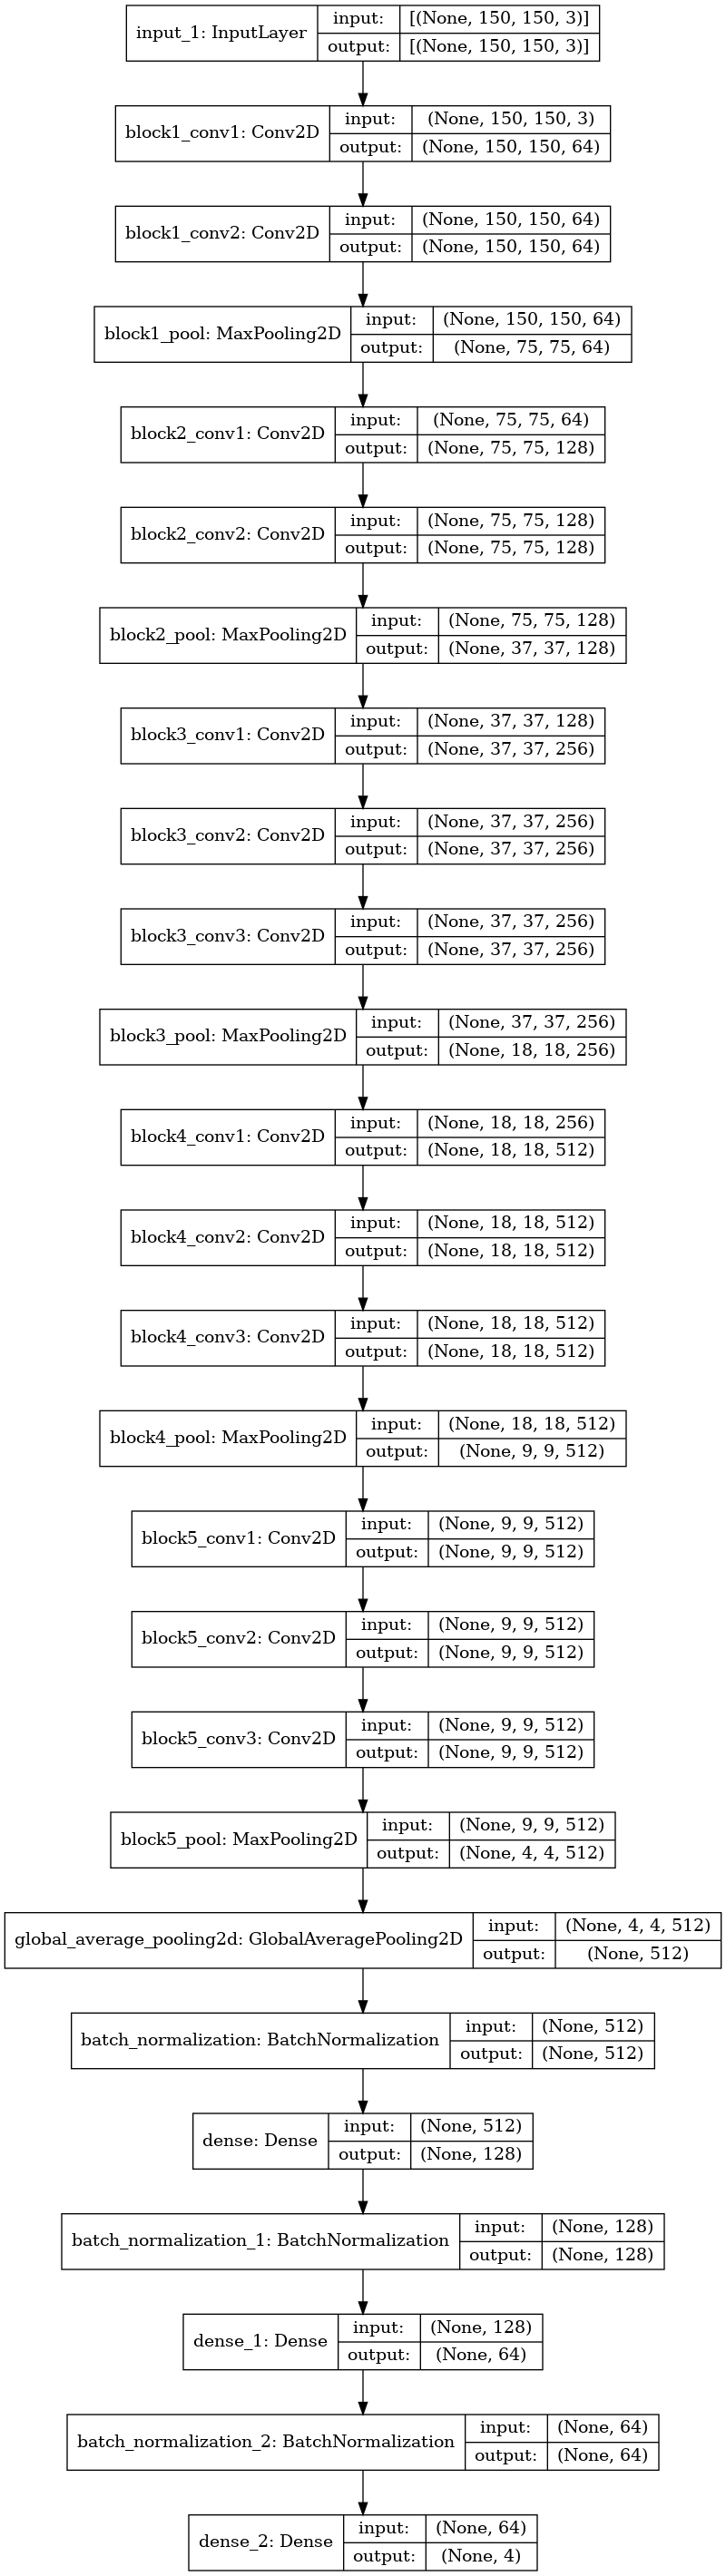

In [11]:
model.summary()
tf.keras.utils.plot_model(model,to_file='model.png', show_shapes=True, show_layer_names=True)

In [12]:
hist = model.fit(x_train, y_train, validation_data=(x_val,y_val), batch_size=32, epochs=10)

2022-10-04 04:22:52.093602: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 965047500 exceeds 10% of free system memory.
2022-10-04 04:22:53.475137: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 965047500 exceeds 10% of free system memory.
2022-10-04 04:22:54.374884: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2022-10-04 04:22:56.728897: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


447/447 [==============================] - 32s 50ms/step - loss: 0.3418 - accuracy: 0.8402 - val_loss: 0.4784 - val_accuracy: 0.7796
Epoch 2/10
447/447 [==============================] - 19s 43ms/step - loss: 0.2605 - accuracy: 0.8782 - val_loss: 0.4655 - val_accuracy: 0.7701
Epoch 3/10
447/447 [==============================] - 19s 43ms/step - loss: 0.2267 - accuracy: 0.8931 - val_loss: 0.4183 - val_accuracy: 0.7994
Epoch 4/10
447/447 [==============================] - 19s 43ms/step - loss: 0.2122 - accuracy: 0.8991 - val_loss: 0.3038 - val_accuracy: 0.8518
Epoch 5/10
447/447 [==============================] - 19s 43ms/step - loss: 0.1964 - accuracy: 0.9070 - val_loss: 0.2533 - val_accuracy: 0.8787
Epoch 6/10
447/447 [==============================] - 19s 43ms/step - loss: 0.1844 - accuracy: 0.9130 - val_loss: 0.2247 - val_accuracy: 0.8906
Epoch 7/10
447/447 [==============================] - 19s 43ms/step - loss: 0.1710 - accuracy: 0.9190 - val_loss: 0.2218 - val_accuracy: 0.8926
Epo

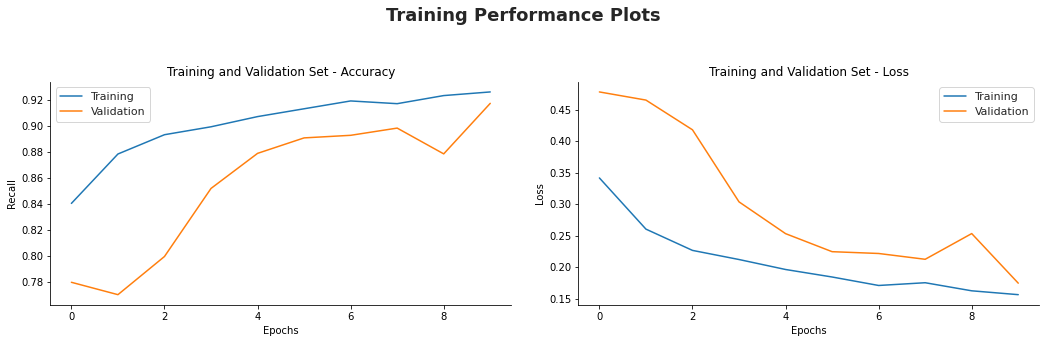

In [13]:
import seaborn as sns

#Plot training and validation Loss
fig, axarr = plt.subplots(1,2, figsize=(15,5),sharex=True)

sns.set(style="ticks", font_scale = 1)
sns.despine(top=True, right=True, left=False, bottom=False)

historyDF = pd.DataFrame.from_dict(hist.history)

ax = sns.lineplot(x =historyDF.index, y = hist.history['accuracy'],ax=axarr[0],label="Training");
ax = sns.lineplot(x =historyDF.index, y = hist.history['val_accuracy'],ax=axarr[0],label="Validation");
ax.set_ylabel('Recall')

ax = sns.lineplot(x =historyDF.index, y = hist.history['loss'],ax=axarr[1],label="Training");
ax = sns.lineplot(x =historyDF.index, y = hist.history['val_loss'],ax=axarr[1],label="Validation");
ax.set_ylabel('Loss')
# ax = sns.lineplot(x =historyDF.index, y = hist.history['lr'],ax=axarr[2]);
# ax.set_ylabel('Learning Rate')    
axarr[0].set_title("Training and Validation Set - Accuracy")
axarr[1].set_title("Training and Validation Set - Loss")
# axarr[2].set_title("Learning Rate during Training")

for ax in axarr:
    ax.set_xlabel('Epochs')
    
plt.suptitle('Training Performance Plots',fontsize=18, weight = 'bold');
fig.tight_layout(pad=2.0)      
plt.show()

### Test and Evaluate model

In [14]:
test_accu = model.evaluate(x_test, y_test)
print('The testing accuracy is :',test_accu[1]*100, '%')

132/132 [==============================] - 5s 38ms/step - loss: 0.1754 - accuracy: 0.9153
The testing accuracy is : 91.53388738632202 %


In [15]:
preds = model.predict(x_test)
predictions = np.argmax(preds, axis=-1)
predictions

array([0, 2, 0, ..., 2, 0, 2])

### Confusion matrix & Classification report

<AxesSubplot:>

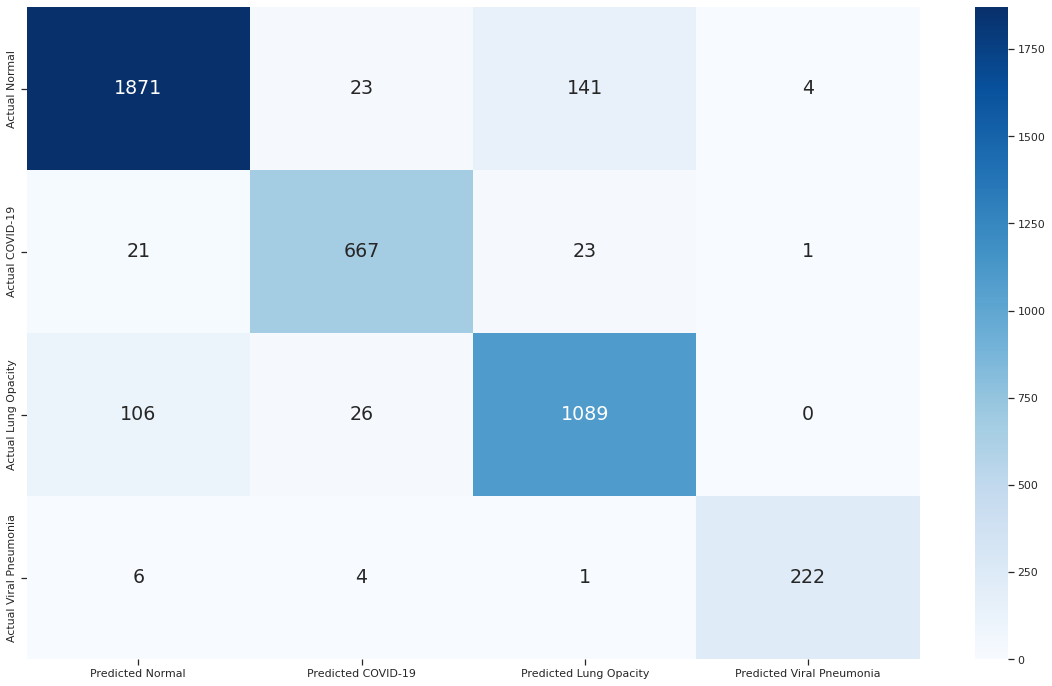

In [16]:
from sklearn.metrics import classification_report,confusion_matrix
cm = pd.DataFrame(data=confusion_matrix(np.argmax(y_test, axis=1), preds.argmax(axis=1), labels=[0,1,2,3]),index=["Actual Normal", "Actual COVID-19", "Actual Lung Opacity", "Actual Viral Pneumonia"],
columns=["Predicted Normal", "Predicted COVID-19", "Predicted Lung Opacity", "Predicted Viral Pneumonia"])
import seaborn as sns
fig, ax = plt.subplots(figsize=(20,12))
plt.rcParams.update({'font.size': 19})
sns.heatmap(cm,cmap="Blues",annot=True,fmt="d",ax=ax)

In [17]:
print(classification_report(y_true=np.argmax(y_test, axis=1),y_pred=preds.argmax(axis=1),target_names =["Normal", "COVID-19", "Lung Opacity", "Viral Pneumonia"]))

                 precision    recall  f1-score   support

         Normal       0.93      0.92      0.93      2039
       COVID-19       0.93      0.94      0.93       712
   Lung Opacity       0.87      0.89      0.88      1221
Viral Pneumonia       0.98      0.95      0.97       233

       accuracy                           0.92      4205
      macro avg       0.93      0.92      0.93      4205
   weighted avg       0.92      0.92      0.92      4205



# Show Result Prediction

if predicted label is equal to real label we can see the text and bar in blue.
if predicted label is not equal to real label we can see the text and bar in red.

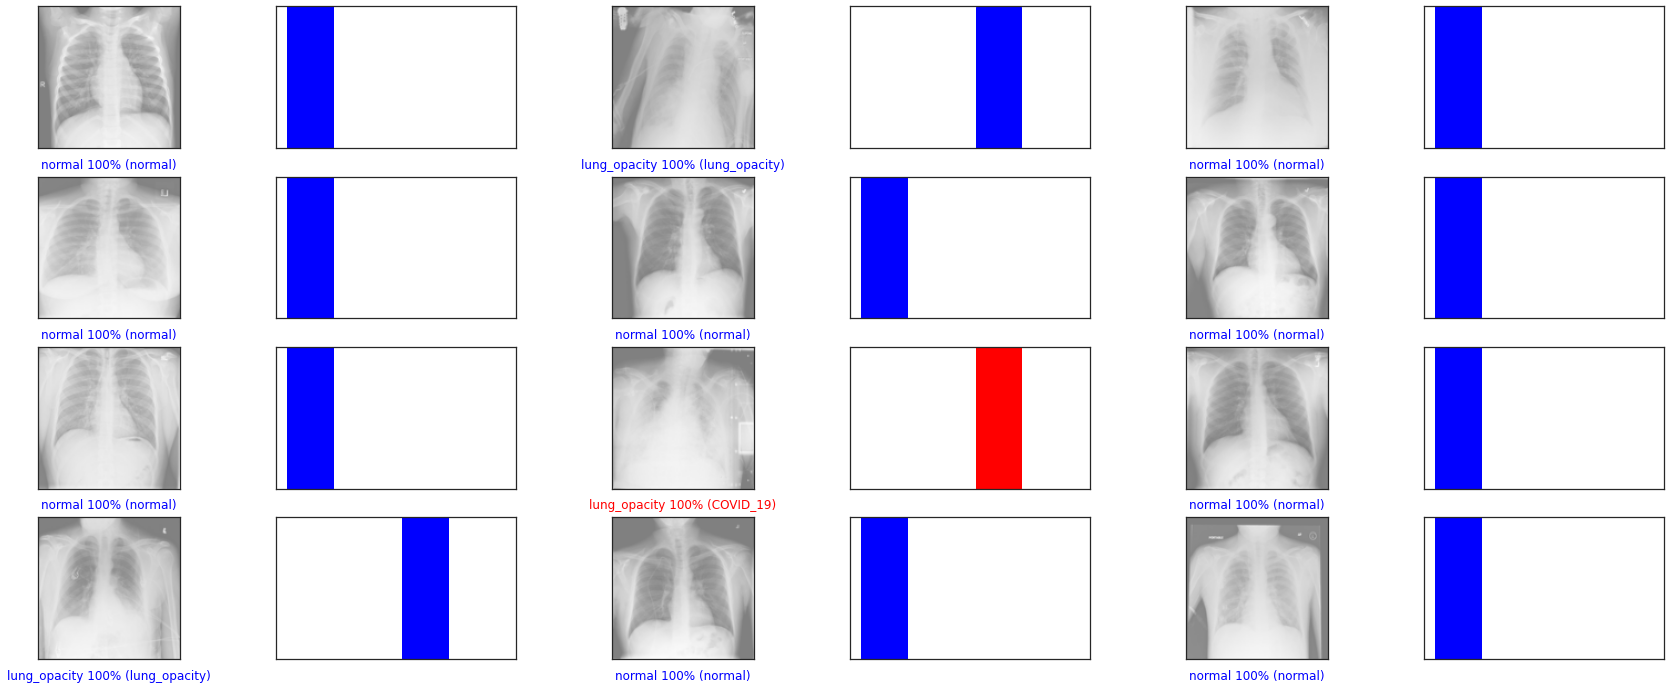

In [18]:
import matplotlib.pyplot as plt

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array[i], true_label[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    thisplot = plt.bar(range(4), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)
    true_label = np.argmax(true_label)
    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    img = cv2.resize(img,(128,128))
    plt.imshow(img, cmap=plt.cm.binary)
    predicted_label = np.argmax(predictions_array)
    true_label= np.argmax(true_label)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'
  
    plt.xlabel("{} {:2.0f}% ({})".format(classNames[predicted_label],
                                100*np.max(predictions_array),
                                classNames[true_label]),
                                color=color)
    
def showResultPrediction(predictions):
    num_rows = 4
    num_cols = 3
    num_images = num_rows*num_cols
    plt.figure(figsize=(5*2*num_cols, 3*num_rows))
    for i in range(num_images):
      plt.subplot(num_rows, 2*num_cols, 2*i+1)
      plot_image(i, predictions, y_test, x_test)
      plt.subplot(num_rows, 2*num_cols, 2*i+2)
      plot_value_array(i, predictions, y_test)
    plt.show()

showResultPrediction(preds)

In [ ]:
# from PIL import Image, ImageOps
# def resize_image(img):
#     # Image.open(imgpath)
#     img = np.array(ImageOps.grayscale(img).resize((150, 150), Image.ANTIALIAS))
#     return img

# def hist(imgpath):
#     img = cv2.imread(imgpath)
#     img_to_yuv = cv2.cvtColor(img,cv2.COLOR_BGR2YUV)
#     img_to_yuv[:,:,0] = cv2.equalizeHist(img_to_yuv[:,:,0])
#     hist_equalization_result = cv2.cvtColor(img_to_yuv, cv2.COLOR_RGB2YUV)
#     return Image.fromarray(hist_equalization_result)

# print(img1)
# print(hist(img1))

# _img = hist(img1)
# print(type(_img))
# print(type(Image.open(img1)))
# _img = resize_image(_img)
# _img
# print(_img)
# plt.imshow(_img)
# plt.show()